# Business Analytics Term Project [Cabbage price prediction]


## Data preprocessing

In [2]:
import pandas as pd
import numpy as np
import os

# 데이터 로드
d_temp = pd.read_csv(r"D:\파일\3학년\3-2\Business Analytics\팀플\데이터\전국_일별기온.csv", 
                     sep=',', encoding='cp949', thousands=',')
d_rain = pd.read_csv(r"D:\파일\3학년\3-2\Business Analytics\팀플\데이터\전국_일별강수량.csv", 
                     sep=',', encoding='cp949', thousands=',')
m_price = pd.read_csv(r"D:\파일\3학년\3-2\Business Analytics\팀플\데이터\월간_소비자물가지수.csv", 
                      sep=',', encoding='cp949', thousands=',')
m_trade = pd.read_csv(r"D:\파일\3학년\3-2\Business Analytics\팀플\데이터\월간_수출수입.csv", 
                      sep=',', encoding='cp949', thousands=',')
y_produce = pd.read_csv(r"D:\파일\3학년\3-2\Business Analytics\팀플\데이터\연간_생산면적생산량.csv", 
                        sep=',', encoding='cp949', thousands=',')

# 배추 가격 데이터 로드
folders = os.listdir('D:/파일/3학년/3-2/Business Analytics/팀플/데이터/배추가격')
d_price = pd.DataFrame()

for i in range(len(folders)):
    if folders[i].split('.')[1] == 'csv':
        file = 'D:/파일/3학년/3-2/Business Analytics/팀플/데이터/배추가격/' + folders[i]
        df = pd.read_csv(file, encoding='cp949', thousands=',') 
        d_price = pd.concat([d_price, df])



In [3]:
# 데이터 병합
d_rain.rename(columns={'날짜':'구분'}, inplace=True)
d_price.rename(columns={'평균':'평균배추가격'}, inplace=True)

d1 = pd.merge(d_price, d_temp, on='구분', how='left')
d2 = pd.merge(d1, d_rain, on='구분', how='left')

# 날짜 처리
d2['Year'] = pd.DatetimeIndex(d2['구분']).year
d2['Month'] = pd.DatetimeIndex(d2['구분']).month
d2['Day'] = pd.DatetimeIndex(d2['구분']).day
d2 = d2.drop(['구분'], axis=1)

# 생산 데이터 병합
y_produce.columns = ['Year', '생산면적 (ha)', '생산량 (톤)']
y_produce['Year'] = y_produce['Year'].astype(int)
d2 = pd.merge(d2, y_produce, how='left')

# 물가 데이터 처리
m_price['시점'] = m_price['시점'].astype(str)
m_price['Year'] = m_price.시점.str.split('.').str[0]
m_price['Month'] = m_price.시점.str.split('.').str[1]
m_price.loc[m_price['Month'] == '1', 'Month'] = '10'
m_price.drop('시점', axis=1, inplace=True)

m_price['Year'] = m_price['Year'].astype(int)
m_price['Month'] = m_price['Month'].astype(int)
d2 = pd.merge(d2, m_price, how='left')

# 무역 데이터 처리
m_trade.dropna(inplace=True)
m_trade['년월'] = m_trade['년월'].astype(str)
m_trade['Year'] = m_trade.년월.str.split('.').str[0]
m_trade['Month'] = m_trade.년월.str.split('.').str[1]
m_trade.loc[m_trade['Month'] == '1', 'Month'] = '10'
m_trade.drop('년월', axis=1, inplace=True)

m_trade['Year'] = m_trade['Year'].astype(int)
m_trade['Month'] = m_trade['Month'].astype(int)

# 수입액 및 수입량 처리
m_trade.rename(columns={'수입액($1000)': '수입액'}, inplace=True)
m_trade.rename(columns={'수입량(kg)': '수입량'}, inplace=True)

m_trade['수입액'] = m_trade['수입액'].astype(int)
m_trade['수입량'] = m_trade['수입량'].astype(int)
m_trade = m_trade.loc[(m_trade.수입액 != 0) | (m_trade.수입량 == 0)]

# 데이터 병합
d2 = pd.merge(d2, m_trade, how='left')
d2.dropna(subset=['수출액($1000)'], inplace=True)

# 결측치 처리
production_min = d2['생산량 (톤)'].min()
d2.fillna(production_min, inplace=True)

# 불필요한 컬럼 제거
d2 = d2.drop(['Year', 'Day', '지점'], axis=1)

# 계절로 변경
d2['Month'] = d2['Month'].astype(str)
d2['Month'] = d2['Month'].replace({
    '10': '가을', '12': '겨울', '1': '겨울', '2': '겨울',
    '3': '봄', '4': '봄', '5': '봄',
    '6': '여름', '7': '여름', '8': '여름',
    '9': '가을', '11': '가을'
}, regex=False)

# 컬럼명 변경
d2.rename(columns={'Month': '계절'}, inplace=True)
d2.rename(columns={'수입액': '수입액($1000)'}, inplace=True)
d2.rename(columns={'수입량': '수입량(kg)'}, inplace=True)

# 계절 sin, cos 변경
season_mapping = {
    '겨울': 0,
    '봄': 1,
    '여름': 2,
    '가을': 3
}

# 계절 변수를 숫자로 변환
d2['계절_numeric'] = d2['계절'].map(season_mapping)
d2['계절_sin'] = np.sin(2 * np.pi * d2['계절_numeric'] / 4)  # 4는 계절 수
d2['계절_cos'] = np.cos(2 * np.pi * d2['계절_numeric'] / 4)

# 불필요한 컬럼 제거
d2 = d2.drop(['계절', '계절_numeric'], axis=1)

# 결과 출력
d2.info()
d2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2486 entries, 20 to 2646
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   평균배추가격      2486 non-null   int64  
 1   평균기온(℃)     2486 non-null   float64
 2   최저기온(℃)     2486 non-null   float64
 3   최고기온(℃)     2486 non-null   float64
 4   강수량(mm)     2486 non-null   float64
 5   생산면적 (ha)   2486 non-null   int64  
 6   생산량 (톤)     2486 non-null   float64
 7   소비자물가지수     2486 non-null   float64
 8   수출액($1000)  2486 non-null   float64
 9   수출량(kg)     2486 non-null   float64
 10  수입액($1000)  2486 non-null   float64
 11  수입량(kg)     2486 non-null   float64
 12  계절_sin      2486 non-null   float64
 13  계절_cos      2486 non-null   float64
dtypes: float64(12), int64(2)
memory usage: 291.3 KB


,평균배추가격,평균기온(℃),최저기온(℃),최고기온(℃),강수량(mm),생산면적 (ha),생산량 (톤),소비자물가지수,수출액($1000),수출량(kg),수입액($1000),수입량(kg),계절_sin,계절_cos
20,3560,-6.5,-10.6,-0.4,0.3,29524,2001642.0,91.588,102.0,179261.0,0.0,0.0,0.0,1.000000e+00
21,3740,-10.2,-13.9,-5.7,0.1,29524,2001642.0,91.588,102.0,179261.0,0.0,0.0,0.0,1.000000e+00
22,3840,-7.0,-13.7,-0.9,0.0,29524,2001642.0,91.588,102.0,179261.0,0.0,0.0,0.0,1.000000e+00
23,4100,1.2,-4.3,6.2,1.6,29524,2001642.0,91.588,102.0,179261.0,0.0,0.0,0.0,1.000000e+00
24,4100,-3.7,-8.5,3.0,0.0,29524,2001642.0,91.588,102.0,179261.0,0.0,0.0,0.0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642,27760,17.8,13.9,23.4,0.0,23853,1793391.0,108.930,33.0,12522.0,627.0,1081765.0,-1.0,-1.836970e-16
2643,26720,18.7,13.2,26.3,0.0,23853,1793391.0,108.930,33.0,12522.0,627.0,1081765.0,-1.0,-1.836970e-16
2644,25860,18.4,13.5,24.8,0.0,23853,1793391.0,108.930,33.0,12522.0,627.0,1081765.0,-1.0,-1.836970e-16
2645,24640,18.6,13.5,26.4,0.0,23853,1793391.0,108.930,33.0,12522.0,627.0,1081765.0,-1.0,-1.836970e-16


     VIF_Factor     Feature
0   2040.345706     평균기온(℃)
1    341.445773     최저기온(℃)
2    920.945739     최고기온(℃)
3      1.601919     강수량(mm)
4    468.550431   생산면적 (ha)
5    382.464619     생산량 (톤)
6    103.808379     소비자물가지수
7     45.561793  수출액($1000)
8     41.360398     수출량(kg)
9     23.254898  수입액($1000)
10    24.599657     수입량(kg)
11     1.198668      계절_sin
12     4.490390      계절_cos


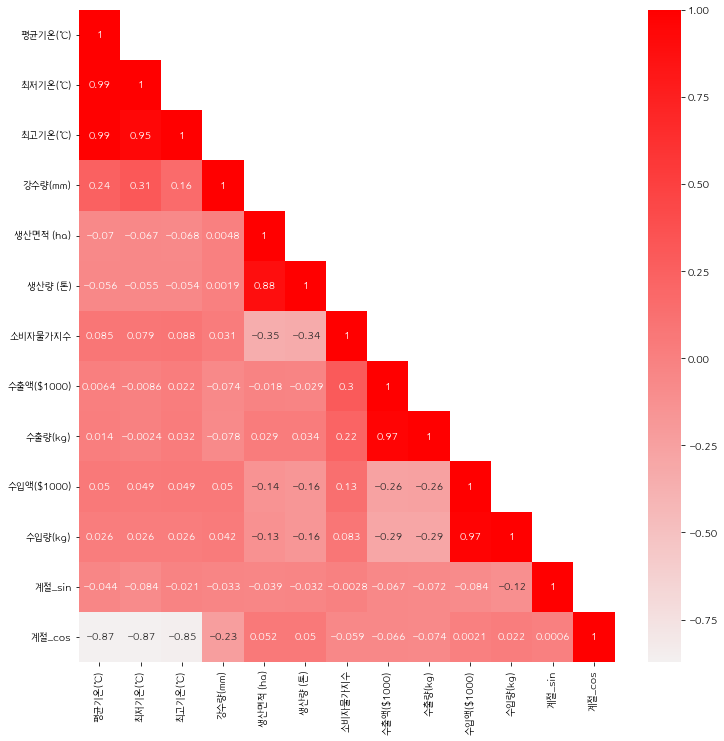

In [4]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train = d2[['평균기온(℃)', '최저기온(℃)', '최고기온(℃)', '강수량(mm)', '생산면적 (ha)', '생산량 (톤)', '소비자물가지수', '수출액($1000)', '수출량(kg)', '수입액($1000)', '수입량(kg)', '계절_sin', '계절_cos']]
y_train = d2[['평균배추가격']]

# VIF 계산 및 출력
def feature_engineering_XbyVIF(X_train):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    return vif

vif = feature_engineering_XbyVIF(X_train)
print(vif)


# 상관관계 분석 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'netmarble'  
plt.rcParams['axes.unicode_minus'] = False   

# feature간의 상관관계
corr_M = X_train.corr()  
mask = np.array(corr_M)   
mask[np.tril_indices_from(mask)] = False  

# 히트맵 시각화
plt.figure(figsize=(12, 12))
sns.heatmap(corr_M, 
            cmap=sns.light_palette("red", as_cmap=True),
            annot=True, 
            mask=mask)

plt.show()


   VIF_Factor  Feature
0   13.121288  평균기온(℃)
1    1.251843  강수량(mm)
2   57.821925  생산량 (톤)
3   69.209122  소비자물가지수
4    2.499515  수출량(kg)
5    1.333612  수입량(kg)
6    1.040796   계절_sin
7    4.355403   계절_cos


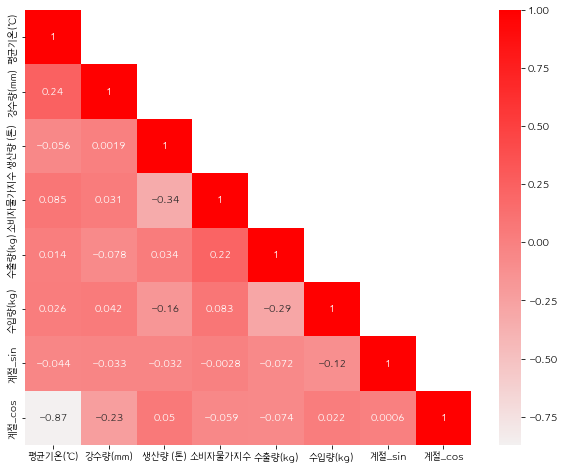

In [5]:
# 불필요한 특성 제거
X_train = X_train.drop(['최저기온(℃)', '최고기온(℃)'], axis=1)
X_train = X_train.drop(['생산면적 (ha)'], axis=1)
X_train = X_train.drop(['수입액($1000)', '수출액($1000)'], axis=1)

# VIF 계산 및 출력
def feature_engineering_XbyVIF(X_train):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    return vif

vif = feature_engineering_XbyVIF(X_train)
print(vif)


plt.rcParams['font.family'] = 'netmarble' 
plt.rcParams['axes.unicode_minus'] = False  

corr_M = X_train.corr()  
mask = np.array(corr_M)   
mask[np.tril_indices_from(mask)] = False 

plt.figure(figsize=(10, 8))
sns.heatmap(corr_M, 
            cmap=sns.light_palette("red", as_cmap=True),
            annot=True, 
            mask=mask)

plt.show()


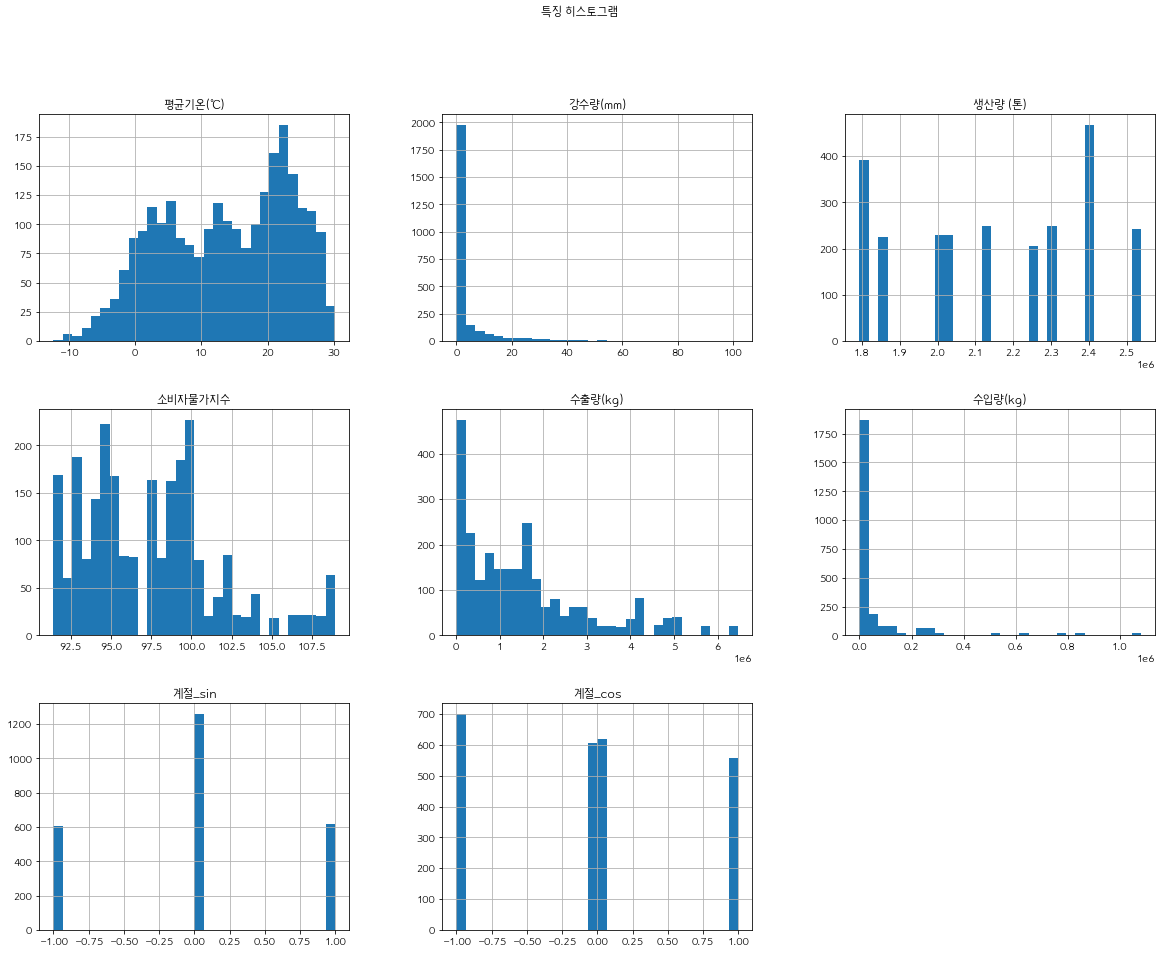

In [6]:
X_train.hist(bins=30, figsize=(20, 15))
plt.suptitle('특징 히스토그램')
plt.show()

<Figure size 1080x720 with 0 Axes>

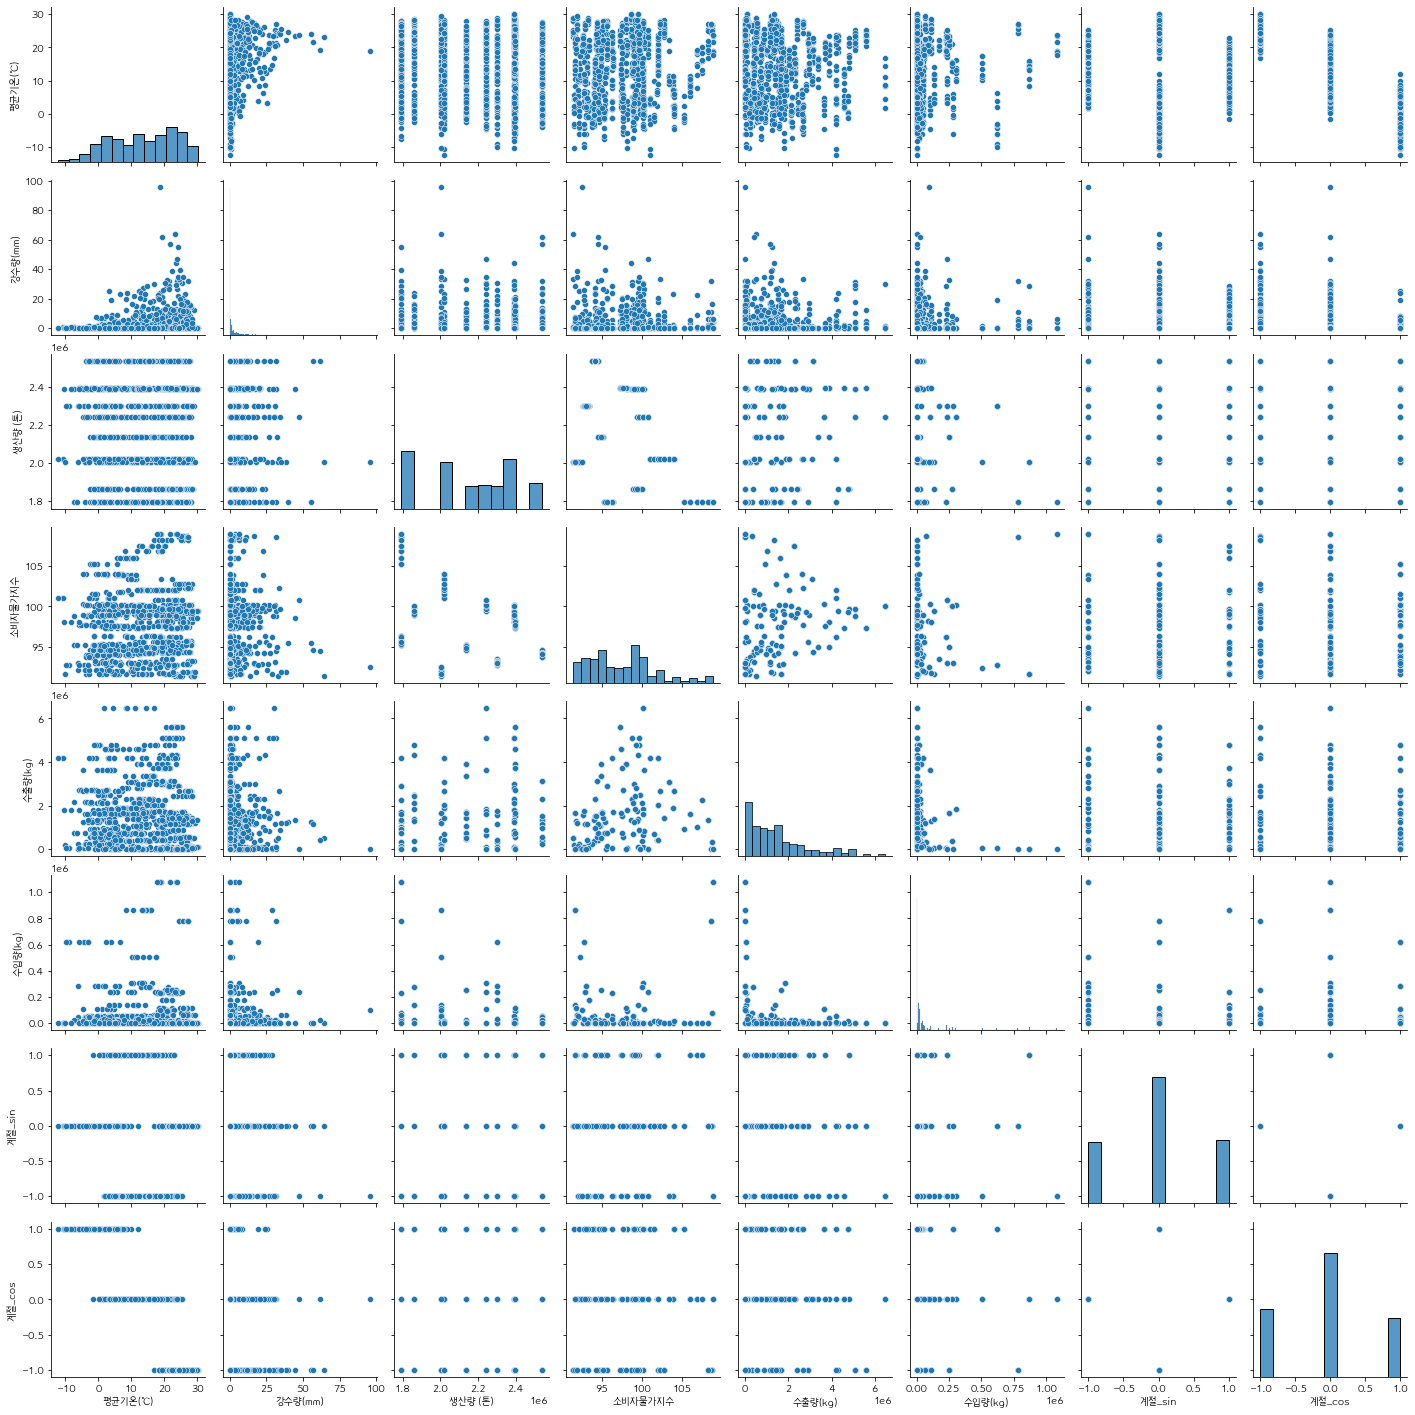

In [7]:
plt.figure(figsize=(15, 10))
sample_data = X_train.sample(n=1000, random_state=1)
sns.pairplot(sample_data)
plt.show()

{'평균기온(℃)': 0, '강수량(mm)': 408, '생산량 (톤)': 0, '소비자물가지수': 83, '수출량(kg)': 121, '수입량(kg)': 411, '계절_sin': 1227, '계절_cos': 0}


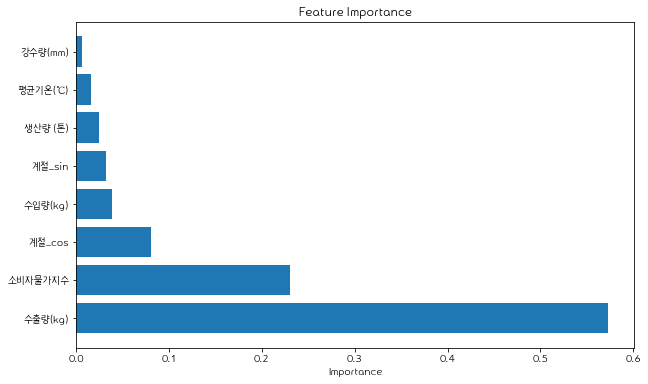

   Feature  Importance
4  수출량(kg)    0.572548
3  소비자물가지수    0.230450
7   계절_cos    0.080586
5  수입량(kg)    0.038037
6   계절_sin    0.032466
2  생산량 (톤)    0.024221
0  평균기온(℃)    0.015527
1  강수량(mm)    0.006165


In [8]:
import xgboost as xgb


outlier_counts = {}

# 각 변수에 대해 이상치 개수 계산
for column in X_train.columns:
    Q1 = X_train[column].quantile(0.25)  # 1사분위수
    Q3 = X_train[column].quantile(0.75)  # 3사분위수
    IQR = Q3 - Q1  
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR 
    outliers = X_train[(X_train[column] < lower_bound) | (X_train[column] > upper_bound)] 
    outlier_counts[column] = len(outliers) 

print(outlier_counts)  # 각 변수별 이상치 개수 출력

# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# 피처 중요도 
importances = xgb_model.feature_importances_

# 피처 이름과 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)  # 중요도 정렬

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

# 중요도 출력
print(importance_df)


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

In [8]:
x=d2.drop('평균배추가격', axis=1)

# 이상치 많고 중요도 낮은 강수량 제거 -> 성능 개선 확인
x = x.drop(['최저기온(℃)','최고기온(℃)','생산면적 (ha)','수입액($1000)','수출액($1000)','강수량(mm)'], axis=1)
y=d2.평균배추가격

x

,평균기온(℃),생산량 (톤),소비자물가지수,수출량(kg),수입량(kg),계절_sin,계절_cos
20,-6.5,2001642.0,91.588,179261.0,0.0,0.0,1.000000e+00
21,-10.2,2001642.0,91.588,179261.0,0.0,0.0,1.000000e+00
22,-7.0,2001642.0,91.588,179261.0,0.0,0.0,1.000000e+00
23,1.2,2001642.0,91.588,179261.0,0.0,0.0,1.000000e+00
24,-3.7,2001642.0,91.588,179261.0,0.0,0.0,1.000000e+00
...,...,...,...,...,...,...,...
2642,17.8,1793391.0,108.930,12522.0,1081765.0,-1.0,-1.836970e-16
2643,18.7,1793391.0,108.930,12522.0,1081765.0,-1.0,-1.836970e-16
2644,18.4,1793391.0,108.930,12522.0,1081765.0,-1.0,-1.836970e-16
2645,18.6,1793391.0,108.930,12522.0,1081765.0,-1.0,-1.836970e-16


In [9]:
x_trainval, x_test, y_trainval, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_trainval

,평균기온(℃),생산량 (톤),소비자물가지수,수출량(kg),수입량(kg),계절_sin,계절_cos
1876,25.1,1859705.0,99.425,1274660.0,0.0,1.224647e-16,-1.000000e+00
2429,8.7,2017507.0,103.870,1879575.0,0.0,-1.000000e+00,-1.836970e-16
1714,4.2,2391946.0,98.988,1248605.0,0.0,0.000000e+00,1.000000e+00
2157,16.3,2242640.0,100.180,1848628.0,303058.0,-1.000000e+00,-1.836970e-16
1871,28.3,1859705.0,99.425,1274660.0,0.0,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...
1071,18.1,1793391.0,95.630,734434.0,57750.0,1.000000e+00,6.123234e-17
1811,21.4,1859705.0,99.652,4793176.0,0.0,1.000000e+00,6.123234e-17
783,4.5,2134976.0,94.596,725126.0,7000.0,1.000000e+00,6.123234e-17
855,22.3,2134976.0,94.909,1647871.0,253004.0,1.224647e-16,-1.000000e+00


## Lasso

In [29]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# KFold validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# 빈 리스트 초기화: 알파 및 다항식 차수 저장을 위한 리스트
alpha_settings = []
d_settings = []

# 데이터 스케일러 초기화
scaler = StandardScaler()
best_r2 = 0  # 최고 R2 점수를 저장하기 위한 변수

# 알파값 후보 생성: 10^-3부터 10^1까지의 로그 스케일로 50개의 값 생성
for alpha in np.logspace(-3, 1, 50):
    print(alpha)
    
    r2_val = []  # 각 알파에 대한 R2 점수를 저장할 리스트
    maxdegree = 6  # 다항식의 최대 차수 설정
    
    # 다항식 차수를 3부터 maxdegree까지 반복
    for d in range(3, maxdegree):
        print(d)
        
        # 현재 알파와 차수를 리스트에 추가
        alpha_settings.append(alpha)
        d_settings.append(d)
        
        # 다항식 변환 설정
        poly = PolynomialFeatures(degree=d, include_bias=False)
        
        # KFold를 사용하여 훈련 및 검증 데이터 인덱스 분할
        for train_idx, val_idx in kfold.split(x_trainval, y_trainval):
            # 훈련 및 검증 데이터 분할
            x_train = x_trainval.iloc[train_idx]
            y_train = y_trainval.iloc[train_idx]
            x_val = x_trainval.iloc[val_idx]
            y_val = y_trainval.iloc[val_idx]

            # 데이터 스케일링
            scaler.fit(x_train)  # 훈련 데이터에 맞춰 스케일러 학습
            x_train_scaled = scaler.transform(x_train)  # 훈련 데이터 스케일링
            x_val_scaled = scaler.transform(x_val)  # 검증 데이터 스케일링

            # 다항식 변환
            poly.fit(x_train_scaled)  # 스케일링된 훈련 데이터에 맞춰 다항식 학습
            x_train_poly = poly.transform(x_train_scaled)  # 훈련 데이터 다항식 변환
            x_val_poly = poly.transform(x_val_scaled)  # 검증 데이터 다항식 변환

            # Lasso 회귀 모델 학습
            lasso = Lasso(alpha=alpha, random_state=0, max_iter=10000)
            lasso.fit(x_train_poly, y_train)  # 현재 알파로 모델 학습

            # 검증 데이터에 대한 예측
            y_val_hat = lasso.predict(x_val_poly)

            # R2 점수 계산 및 저장
            r2_val.append(r2_score(y_val, y_val_hat))

        mean_r2 = np.mean(r2_val)  # 교차 검증 점수의 평균 계산

        # 평균 R2 점수를 리스트에 저장
        mean_r2_scores.append(mean_r2)

        # 현재 평균 점수가 최고 점수보다 높으면 업데이트
        if mean_r2 > best_r2:        
            best_r2 = mean_r2
            best_parameters = {'alpha': alpha, 'degree': d}  # 최적 하이퍼파라미터 저장

# 최고 점수 및 알파값 출력
print("Best score on validation set: {:.7f}".format(best_r2))
print("Best hyperparameters: {}".format(best_parameters))

0.001
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.421e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.328e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.078e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.146e+09, toler

0.0012067926406393288
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.421e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.328e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.146e+09, toler

0.0014563484775012444
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.328e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+09, toler

0.0017575106248547913
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.329e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+09, toler

0.0021209508879201904
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.329e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.080e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+09, toler

0.002559547922699536
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.080e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.148e+09, toler

0.0030888435964774815
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.080e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.148e+09, toler

0.003727593720314938
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.081e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.149e+09, toler

0.004498432668969444
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.332e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.081e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.149e+09, toler

0.005428675439323859
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.332e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.150e+09, toler

0.006551285568595509
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.529e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.333e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.239e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.150e+09, toler

0.0079060432109077
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.529e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.334e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.083e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+09, toler

0.009540954763499945
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.529e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.303e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.335e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.241e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.084e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.152e+09, toler

0.01151395399326447
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.529e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.303e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.428e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.242e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.085e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.153e+09, toler

0.013894954943731374
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.528e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.303e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.337e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.243e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.086e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.154e+09, toler

0.016768329368110076
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.528e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.302e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.262e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.241e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.338e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.245e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.088e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+09, toler

0.020235896477251564
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.527e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.301e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.262e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.432e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.243e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.339e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.157e+09, toler

0.02442053094548651
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.525e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.300e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.261e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.244e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.249e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.087e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.160e+09, toler

0.029470517025518096
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.524e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.259e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.435e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.245e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.248e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.162e+09, toler

0.03556480306223128
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.524e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.297e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.258e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.245e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.251e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.165e+09, toler

0.04291934260128776
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.523e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.294e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.256e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.437e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.347e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.253e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.092e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.163e+09, toler

0.0517947467923121
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.522e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.297e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.254e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.350e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.256e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.096e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.165e+09, toler

0.0625055192527397
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.520e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.295e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.256e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.259e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.260e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.099e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.166e+09, toler

0.07543120063354615
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.518e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.294e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.255e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.264e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.103e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.167e+09, toler

0.09102981779915217
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.516e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.292e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.253e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.111e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.168e+09, toler

0.10985411419875583
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.513e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.250e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.468e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.276e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+09, toler

0.13257113655901082
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.508e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.285e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.247e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.284e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.280e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.122e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.196e+09, toler

0.15998587196060574
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.503e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.243e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.293e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.286e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.124e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.196e+09, toler

0.19306977288832497
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.498e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.276e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.239e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.397e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+09, toler

0.2329951810515372
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.488e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.269e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.511e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.326e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.164e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e+09, toler

0.2811768697974228
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.481e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.261e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.225e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.523e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.326e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.417e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.179e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.243e+09, toler

0.3393221771895326
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.474e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.535e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.345e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.434e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.350e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.192e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.259e+09, toler

0.4094915062380423
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.464e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.206e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.367e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.207e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e+09, toler

0.49417133613238334
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.442e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.204e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.192e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.455e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e+09, toler

0.5963623316594643
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.410e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.484e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.243e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.309e+09, toler

0.7196856730011514
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.363e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.134e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.613e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.418e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.438e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.339e+09, toler

0.868511373751352
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.428e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.294e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e+09, toler

1.0481131341546852
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.215e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.978e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.484e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.324e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.397e+09, toler

1.2648552168552958
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.531e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.361e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e+09, toler

1.5264179671752318
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.001e+08, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.208e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.573e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e+09, toler

1.8420699693267144
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+09, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.652e+08, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.884e+08, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.617e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.505e+09, toler

2.2229964825261934
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.044e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.397e+08, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.021e+08, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.796e+08, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.163e+08, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.471e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e+09, toler

2.6826957952797246
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.048e+08, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.461e+08, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e+08, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e+09, toler

3.2374575428176433
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.622e+07, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+08, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.497e+07, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.461e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e+09, toler

3.906939937054613
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.447e+07, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.005e+08, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e+08, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e+09, toler

4.714866363457389
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.363e+08, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.346e+07, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.768e+07, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.676e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.561e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e+09, toler

5.689866029018293
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e+08, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.191e+07, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.770e+06, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.742e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.630e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+09, toler

6.866488450042998
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.106e+08, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e+07, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.457e+07, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.345e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.555e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.152e+09, toler

8.286427728546842
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.088e+07, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.318e+06, tolerance: 3.656e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e+07, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.449e+08, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e+09, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.030e+09, toler

10.0
3


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.323e+07, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.913e+06, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.041e+07, toler

4


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.199e+08, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.840e+08, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e+09, toler

5


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.773e+08, tolerance: 3.994e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e+09, tolerance: 3.667e+06
  model = cd_fast.enet_coordinate_descent(
c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.985e+08, toler

Best score on validation set: 0.8905128
Best hyperparameters: {'alpha': 0.2811768697974228, 'degree': 5}


c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.544e+08, tolerance: 3.510e+06
  model = cd_fast.enet_coordinate_descent(


In [12]:
scaler = StandardScaler()
scaler.fit(x_trainval)
x_trainval_scaled = scaler.transform(x_trainval)
x_test_scaled = scaler.transform(x_test)

poly = PolynomialFeatures(degree=5, include_bias=False)
poly.fit(x_trainval_scaled)
x_trainval_poly = poly.transform(x_trainval_scaled)
x_test_poly = poly.transform(x_test_scaled)

alpha_value = 0.2811768697974228  
lasso = Lasso(alpha=alpha_value, random_state=0, max_iter=10000)
lasso.fit(x_trainval_poly, y_trainval)


y_test_hat = lasso.predict(x_test_poly)

# 성능 평가
test_score = r2_score(y_test, y_test_hat)
mse = mean_squared_error(y_test, y_test_hat)  
rmse = mean_squared_error(y_test, y_test_hat, squared=False)  
mae = mean_absolute_error(y_test, y_test_hat) 


results = pd.DataFrame({
    'Metric': ['Alpha', 'R² Score', 'MSE', 'RMSE', 'MAE'],
    'Lasso': [alpha_value, test_score, mse, rmse, mae]
})

# 결과 출력
results

c:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.539e+09, tolerance: 4.680e+06
  model = cd_fast.enet_coordinate_descent(


,Metric,Lasso
0,Alpha,2.811769e-01
1,R² Score,9.109783e-01
2,MSE,2.160095e+06
3,RMSE,1.469726e+03
4,MAE,8.183509e+02


## Ridge

In [24]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# 빈 리스트 초기화
alpha_settings = []
d_settings = []
# 평균 R2 점수를 저장할 리스트
mean_r2_scores = []  # alpha에 대한 평균 R2 점수를 저장할 리스트

scaler = StandardScaler()


best_r2=0

for alpha in np.logspace(-3, 1, 50): # candidates for alpha
    
    print(alpha)
    
    r2_val = []
    maxdegree=6
    
    for d in range(2,maxdegree):
        
        print(d)
        
        alpha_settings.append(alpha)
        d_settings.append(d)
            
        poly = PolynomialFeatures(degree=d,include_bias=False)
            
        for train_idx, val_idx in kfold.split(x_trainval, y_trainval):
            
            x_train = x_trainval.iloc[train_idx]
            y_train = y_trainval.iloc[train_idx]
            x_val = x_trainval.iloc[val_idx]
            y_val = y_trainval.iloc[val_idx]

            # x_train_cat = x_train[['계절']]
            # x_train_num = x_train[['평균기온(℃)', '최저기온(℃)', '최고기온(℃)', '강수량(mm)', '생산면적 (ha)', '생산량 (톤)', '소비자물가지수', '수출액($1000)', '수출량(kg)', '수입액($1000)', '수입량(kg)']]

            # x_val_cat = x_val[['계절']]
            # x_val_num = x_val[['평균기온(℃)', '최저기온(℃)', '최고기온(℃)', '강수량(mm)', '생산면적 (ha)', '생산량 (톤)', '소비자물가지수', '수출액($1000)', '수출량(kg)', '수입액($1000)', '수입량(kg)']]


            # # For x_train_cat and x_val_cat, apply onehotencoding
            # ohe = OneHotEncoder(sparse=False)
            # ohe.fit(x_train_cat)

            # x_train_cat_ohe = ohe.transform(x_train_cat)
            # x_val_cat_ohe = ohe.transform(x_val_cat)


            # For x_train_num and x_val_num, apply standardscaler
            scaler = StandardScaler()
            scaler.fit(x_train)

            x_train_scaled = scaler.transform(x_train)
            x_val_scaled = scaler.transform(x_val)

            poly.fit(x_train_scaled)
            x_train_poly = poly.transform(x_train_scaled)
            x_val_poly = poly.transform(x_val_scaled)
        
        
            # # concatenate them agin into x_train and X_val. 
            # x_train_trans = np.concatenate([x_train_cat_ohe, x_train_poly], axis=1)
            # x_val_trans = np.concatenate([x_val_cat_ohe, x_val_poly], axis=1)


            # training is performed with the Lasso set to the current alpha.
            ridge = Ridge(alpha = alpha, random_state=0, max_iter=10000)
            ridge.fit(x_train_poly, y_train)

            # get y_valid_hat with the trained model & store r2 score in scores_val
            y_val_hat= ridge.predict(x_val_poly)

            # store r2 score,mse
            r2_val.append(r2_score(y_val, y_val_hat))

        
        mean_r2 = np.mean(r2_val) # get the cross-validation score

        # 반복문 안에서 mean_r2 저장
        mean_r2_scores.append(mean_r2)
    
        # When the mean_score is higher than current best score,best_score is updated and the hyperparameter at that time is saved
        if mean_r2 > best_r2:        
            best_r2 = mean_r2
            best_parameters = {'alpha': alpha,'degree': d}

print("Best score on validation set: {:.7f}".format(best_r2))
print("Best hyperparameters: {}".format(best_parameters))

0.001
2
3
4
5
0.0012067926406393288
2
3
4
5
0.0014563484775012444
2
3
4
5
0.0017575106248547913
2
3
4
5
0.0021209508879201904
2
3
4
5
0.002559547922699536
2
3
4
5
0.0030888435964774815
2
3
4
5
0.003727593720314938
2
3
4
5
0.004498432668969444
2
3
4
5
0.005428675439323859
2
3
4
5
0.006551285568595509
2
3
4
5
0.0079060432109077
2
3
4
5
0.009540954763499945
2
3
4
5
0.01151395399326447
2
3
4
5
0.013894954943731374
2
3
4
5
0.016768329368110076
2
3
4
5
0.020235896477251564
2
3
4
5
0.02442053094548651
2
3
4
5
0.029470517025518096
2
3
4
5
0.03556480306223128
2
3
4
5
0.04291934260128776
2
3
4
5
0.0517947467923121
2
3
4
5
0.0625055192527397
2
3
4
5
0.07543120063354615
2
3
4
5
0.09102981779915217
2
3
4
5
0.10985411419875583
2
3
4
5
0.13257113655901082
2
3
4
5
0.15998587196060574
2
3
4
5
0.19306977288832497
2
3
4
5
0.2329951810515372
2
3
4
5
0.2811768697974228
2
3
4
5
0.3393221771895326
2
3
4
5
0.4094915062380423
2
3
4
5
0.49417133613238334
2
3
4
5
0.5963623316594643
2
3
4
5
0.7196856730011514
2
3

In [11]:
scaler = StandardScaler()
scaler.fit(x_trainval)
x_trainval_scaled = scaler.transform(x_trainval)
x_test_scaled = scaler.transform(x_test)

poly = PolynomialFeatures(degree=5, include_bias=False)
poly.fit(x_trainval_scaled)
x_trainval_poly = poly.transform(x_trainval_scaled)
x_test_poly = poly.transform(x_test_scaled)

ridge_alpha_value = 0.19306977288832497  # Ridge 하이퍼파라미터
ridge = Ridge(alpha=ridge_alpha_value, random_state=0, max_iter=10000)
ridge.fit(x_trainval_poly, y_trainval)

y_test_hat_ridge = ridge.predict(x_test_poly)

# 성능 평가
ridge_test_score = r2_score(y_test, y_test_hat_ridge)
ridge_mse = mean_squared_error(y_test, y_test_hat_ridge)  
ridge_rmse = mean_squared_error(y_test, y_test_hat_ridge, squared=False)  
ridge_mae = mean_absolute_error(y_test, y_test_hat_ridge) 

ridge_results = pd.DataFrame({
    'Metric': ['Alpha', 'R² Score', 'MSE', 'RMSE', 'MAE'],
    'Ridge': [ridge_alpha_value, ridge_test_score, ridge_mse, ridge_rmse, ridge_mae]
})

# 결과 출력
ridge_results

,Metric,Ridge
0,Alpha,1.930698e-01
1,R² Score,9.096030e-01
2,MSE,2.193466e+06
3,RMSE,1.481035e+03
4,MAE,8.234675e+02


In [27]:
from tabulate import tabulate
import pandas as pd

# 결과 통합 (알파를 제외한 성능 지표만 포함)
final_results = pd.DataFrame({
    'Metric': ['R² Score', 'MSE', 'RMSE', 'MAE'],  # 알파 제외
    'Lasso': [float(value) for value in results['Lasso'][1:]],  # 성능 지표만 포함 (알파 제외)
    'Ridge': [float(value) for value in ridge_results['Ridge'][1:]]  # 성능 지표만 포함 (알파 제외)
})

# MSE와 MAE를 포맷팅하여 일반 숫자로 표시
final_results['Lasso'] = final_results['Lasso'].apply(lambda x: f"{x:,.4f}")
final_results['Ridge'] = final_results['Ridge'].apply(lambda x: f"{x:,.4f}")

# 표 형식으로 크게 출력
print(tabulate(final_results, headers='keys', tablefmt='fancy_grid', stralign='center', numalign='center'))





╒════╤══════════╤════════════════╤════════════════╕
│    │  Metric  │     Lasso      │     Ridge      │
╞════╪══════════╪════════════════╪════════════════╡
│ 0  │ R² Score │     0.9110     │     0.9096     │
├────┼──────────┼────────────────┼────────────────┤
│ 1  │   MSE    │ 2,160,094.5365 │ 2,193,466.1081 │
├────┼──────────┼────────────────┼────────────────┤
│ 2  │   RMSE   │   1,469.7260   │   1,481.0355   │
├────┼──────────┼────────────────┼────────────────┤
│ 3  │   MAE    │    818.3509    │    823.4675    │
╘════╧══════════╧════════════════╧════════════════╛


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19556\4039833621.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(['Lasso', 'Ridge'], fontsize=14)  # x축 라벨 크기 증가
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19556\4039833621.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(['Lasso', 'Ridge'], fontsize=14)  # x축 라벨 크기 증가
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19556\4039833621.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(['Lasso', 'Ridge'], fontsize=14)  # x축 라벨 크기 증가
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19556\4039833621.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(['Lasso', 'Ridge'], fontsize=14)  # x축 라벨 크기 증가


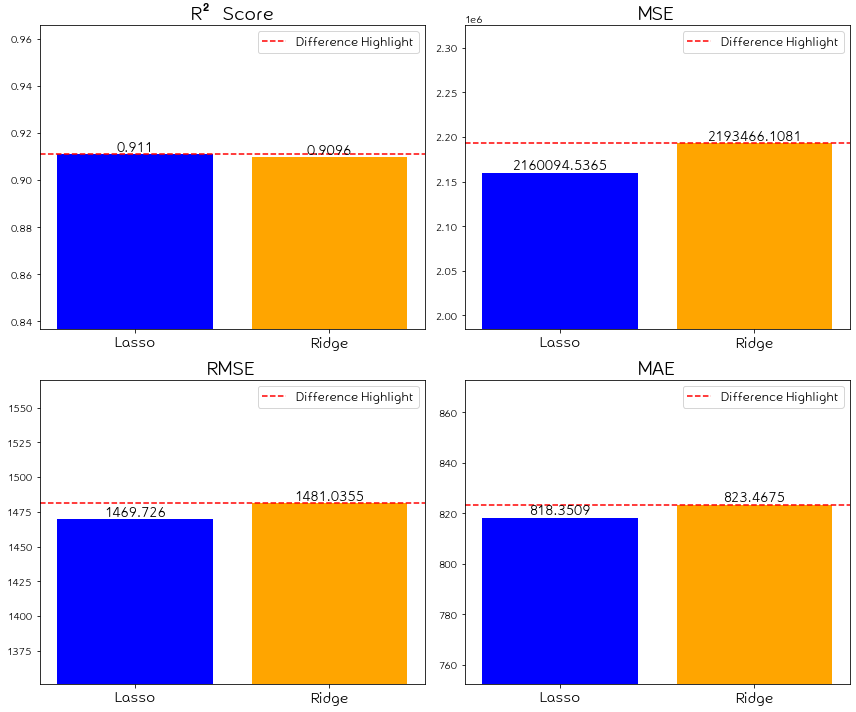

In [59]:
# 성능 지표
metrics = ['R² Score', 'MSE', 'RMSE', 'MAE']
lasso_values = [results['Lasso'][1], results['Lasso'][2], results['Lasso'][3], results['Lasso'][4]]
ridge_values = [ridge_results['Ridge'][1], ridge_results['Ridge'][2], ridge_results['Ridge'][3], ridge_results['Ridge'][4]]

# 서브플롯 
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()  #

# 각 성능 지표에 대한 바 차트 
for i, metric in enumerate(metrics):
    # 바 차트
    axs[i].bar(['Lasso', 'Ridge'], [lasso_values[i], ridge_values[i]], color=['blue', 'orange'])
    axs[i].set_title(f"{metric}", fontsize=18) 
    
    # y축 범위 설정
    max_value = max(lasso_values[i], ridge_values[i])
    axs[i].set_ylim(min(lasso_values[i], ridge_values[i]) - 0.08 * max_value, max_value * 1.06) 

    # 차이 강조 선 추가
    axs[i].axhline(y=min(lasso_values[i], ridge_values[i]) + differences[i], color='red', linestyle='--', label='Difference Highlight')
    axs[i].legend(fontsize=12)

    # x축 라벨 크기
    axs[i].set_xticklabels(['Lasso', 'Ridge'], fontsize=14)  

    # 값 표시
    for bar in axs[i].containers[0]:
        yval = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom', fontsize=13)

plt.tight_layout()
plt.show()